In [ ]:
!pip install albumentations wandb nbformat opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import nbformat
import cv2

from collections import Counter
import logging
import os

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

In [ ]:
data_transforms = {
    "train": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        A.RandomBrightnessContrast(brightness_limit=(-0.15,0.15), contrast_limit=(-0.15, 0.15), p=0.3),
        #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
        A.GaussNoise(var_limit=(10, 50), p=0.1),
        A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
        #A.RandomCrop(224, 224, 0.3),  # RandomCrop to introduce variability
        # A.CenterCrop(height=config['crop'], width=config['crop']),
        # choose mean and std based on pre-trained model specification.
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "validation": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "test": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
}


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dir_root, split, transform=None, resize=None):
        self.dir_root = dir_root
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []

        data_dir = os.path.join(dir_root, split)

        class_directories = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_directories):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)

        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        return len(self.class_names)

    def get_class_name(self, class_idx):
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        return self.class_names

    def class_idx_to_name_dict(self):
        return self.class_idx_to_name

    def get_classes_frequencies(self):
        return dict(Counter(self.targets))

In [ ]:
data_directory = "/content/drive/MyDrive/original(resized)"

In [ ]:
training_dataset = CustomDataset(dir_root=data_directory, split='train', transform=data_transforms['train'])
validation_dataset = CustomDataset(dir_root=data_directory, split='validation', transform=data_transforms['validation'])
test_dataset = CustomDataset(dir_root=data_directory, split='test', transform=data_transforms['test'])

In [ ]:
print(training_dataset.num_classes())
print(training_dataset.get_class_names())
print(training_dataset.get_classes_frequencies())

8
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
{0: 128, 1: 128, 2: 128, 3: 128, 4: 128, 5: 128, 6: 128, 7: 135}


In [ ]:
# pin_memory=Ture allows faster transfer of data from host (CPU) to device (GPU) memory
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
model

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
in_features = model.classifier.fc.in_features

model.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.2, inplace=False),
    torch.nn.Linear(in_features=in_features, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, training_dataset.num_classes()),
)

In [ ]:
model

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# model = torch.compile(model)

In [ ]:
num_epochs = 40
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0.001)

In [ ]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    notes="frozen; CALCULATE ENERGY; 3 layers; data augmentation",
    save_code=False,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "architecture": "efficientnet",
        "dataset": "augmented"
    },
)

wandb: Currently logged in as: prince_. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.watch(model, log="all")

[]

In [ ]:
from tqdm import tqdm

In [ ]:
def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()

    # if epoch == 6:
    #     for param in model.parameters():
    #         param.requires_grad = True

    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        # non_blocking=True allows to transfer data asynchroneously between CPU and GPU
        # it means non_blocking allows to excetue other lines of code without finishing for this line of code to finish
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss/len(dataloader)
    print(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(training_dataset.num_classes()), yticklabels=range(training_dataset.num_classes()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    print(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [ ]:
import copy

f1_best = float('-inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, train_dataloader, criterion, optimizer, device)
    _, _, _, _, f1 = validation(epoch, model, val_dataloader, criterion, device)

    if f1 > f1_best:
        f1_best = f1
        best_model_state_dict = copy.deepcopy(model.state_dict())

if best_model_state_dict:
    model.load_state_dict(best_model_state_dict)

100%|██████████| 33/33 [03:07<00:00,  5.68s/it]

Epoch: [1], Training Loss:  1.2814


Epoch: [1], Validation Loss:  1.0831, Accuracy:  0.5703, Precision:  0.6437, Recall:  0.5703, F1 Score:  0.5395


100%|██████████| 33/33 [00:09<00:00,  3.41it/s]

Epoch: [2], Training Loss:  0.6595


Epoch: [2], Validation Loss:  0.8818, Accuracy:  0.6719, Precision:  0.7201, Recall:  0.6719, F1 Score:  0.6625


100%|██████████| 33/33 [00:07<00:00,  4.43it/s]

Epoch: [3], Training Loss:  0.4818


Epoch: [3], Validation Loss:  0.5756, Accuracy:  0.7578, Precision:  0.7756, Recall:  0.7578, F1 Score:  0.7569


100%|██████████| 33/33 [00:09<00:00,  3.42it/s]

Epoch: [4], Training Loss:  0.3880


Epoch: [4], Validation Loss:  0.4311, Accuracy:  0.8125, Precision:  0.8120, Recall:  0.8125, F1 Score:  0.7985


100%|██████████| 33/33 [00:08<00:00,  3.97it/s]

Epoch: [5], Training Loss:  0.4063


Epoch: [5], Validation Loss:  0.3954, Accuracy:  0.8281, Precision:  0.8255, Recall:  0.8281, F1 Score:  0.8213


100%|██████████| 33/33 [00:08<00:00,  4.08it/s]

Epoch: [6], Training Loss:  0.4397


Epoch: [6], Validation Loss:  0.3666, Accuracy:  0.8516, Precision:  0.8477, Recall:  0.8516, F1 Score:  0.8458


100%|██████████| 33/33 [00:10<00:00,  3.12it/s]

Epoch: [7], Training Loss:  0.3805


Epoch: [7], Validation Loss:  0.3257, Accuracy:  0.8516, Precision:  0.8544, Recall:  0.8516, F1 Score:  0.8509


100%|██████████| 33/33 [00:07<00:00,  4.24it/s]

Epoch: [8], Training Loss:  0.3163


Epoch: [8], Validation Loss:  0.3001, Accuracy:  0.8984, Precision:  0.9003, Recall:  0.8984, F1 Score:  0.8966


100%|██████████| 33/33 [00:08<00:00,  3.79it/s]

Epoch: [9], Training Loss:  0.3093


Epoch: [9], Validation Loss:  0.3161, Accuracy:  0.8828, Precision:  0.8953, Recall:  0.8828, F1 Score:  0.8813


100%|██████████| 33/33 [00:09<00:00,  3.39it/s]

Epoch: [10], Training Loss:  0.3263


Epoch: [10], Validation Loss:  0.2936, Accuracy:  0.8984, Precision:  0.9045, Recall:  0.8984, F1 Score:  0.8978


100%|██████████| 33/33 [00:07<00:00,  4.42it/s]

Epoch: [11], Training Loss:  0.3093


Epoch: [11], Validation Loss:  0.2718, Accuracy:  0.9141, Precision:  0.9165, Recall:  0.9141, F1 Score:  0.9139


100%|██████████| 33/33 [00:10<00:00,  3.27it/s]

Epoch: [12], Training Loss:  0.2693


Epoch: [12], Validation Loss:  0.2906, Accuracy:  0.8906, Precision:  0.9076, Recall:  0.8906, F1 Score:  0.8930


100%|██████████| 33/33 [00:08<00:00,  3.95it/s]

Epoch: [13], Training Loss:  0.2570


Epoch: [13], Validation Loss:  0.2869, Accuracy:  0.8906, Precision:  0.8942, Recall:  0.8906, F1 Score:  0.8903


100%|██████████| 33/33 [00:08<00:00,  3.98it/s]

Epoch: [14], Training Loss:  0.2509


Epoch: [14], Validation Loss:  0.2933, Accuracy:  0.8984, Precision:  0.9060, Recall:  0.8984, F1 Score:  0.8988


100%|██████████| 33/33 [00:10<00:00,  3.25it/s]

Epoch: [15], Training Loss:  0.2681


Epoch: [15], Validation Loss:  0.2908, Accuracy:  0.8906, Precision:  0.9103, Recall:  0.8906, F1 Score:  0.8926


100%|██████████| 33/33 [00:09<00:00,  3.42it/s]

Epoch: [16], Training Loss:  0.2110


Epoch: [16], Validation Loss:  0.2711, Accuracy:  0.8750, Precision:  0.8795, Recall:  0.8750, F1 Score:  0.8744


100%|██████████| 33/33 [00:09<00:00,  3.31it/s]

Epoch: [17], Training Loss:  0.2071


Epoch: [17], Validation Loss:  0.2891, Accuracy:  0.8984, Precision:  0.9259, Recall:  0.8984, F1 Score:  0.9034


100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

Epoch: [18], Training Loss:  0.2277


Epoch: [18], Validation Loss:  0.2787, Accuracy:  0.9062, Precision:  0.9137, Recall:  0.9062, F1 Score:  0.9077


100%|██████████| 33/33 [00:07<00:00,  4.39it/s]

Epoch: [19], Training Loss:  0.2240


Epoch: [19], Validation Loss:  0.2851, Accuracy:  0.8906, Precision:  0.9030, Recall:  0.8906, F1 Score:  0.8922


100%|██████████| 33/33 [00:09<00:00,  3.43it/s]

Epoch: [20], Training Loss:  0.2072


Epoch: [20], Validation Loss:  0.2310, Accuracy:  0.9219, Precision:  0.9244, Recall:  0.9219, F1 Score:  0.9223


100%|██████████| 33/33 [00:08<00:00,  3.87it/s]

Epoch: [21], Training Loss:  0.1735


Epoch: [21], Validation Loss:  0.2436, Accuracy:  0.9219, Precision:  0.9358, Recall:  0.9219, F1 Score:  0.9242


100%|██████████| 33/33 [00:07<00:00,  4.14it/s]

Epoch: [22], Training Loss:  0.1721


Epoch: [22], Validation Loss:  0.2513, Accuracy:  0.9062, Precision:  0.9296, Recall:  0.9062, F1 Score:  0.9095


100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

Epoch: [23], Training Loss:  0.1403


Epoch: [23], Validation Loss:  0.2708, Accuracy:  0.8984, Precision:  0.9172, Recall:  0.8984, F1 Score:  0.9022


100%|██████████| 33/33 [00:07<00:00,  4.20it/s]

Epoch: [24], Training Loss:  0.1828


Epoch: [24], Validation Loss:  0.3157, Accuracy:  0.8984, Precision:  0.9086, Recall:  0.8984, F1 Score:  0.9016


100%|██████████| 33/33 [00:08<00:00,  3.67it/s]

Epoch: [25], Training Loss:  0.1819


Epoch: [25], Validation Loss:  0.3596, Accuracy:  0.8828, Precision:  0.8831, Recall:  0.8828, F1 Score:  0.8793


100%|██████████| 33/33 [00:09<00:00,  3.40it/s]

Epoch: [26], Training Loss:  0.1812


Epoch: [26], Validation Loss:  0.3215, Accuracy:  0.8828, Precision:  0.8913, Recall:  0.8828, F1 Score:  0.8846


100%|██████████| 33/33 [00:07<00:00,  4.33it/s]

Epoch: [27], Training Loss:  0.2141


Epoch: [27], Validation Loss:  0.2971, Accuracy:  0.8750, Precision:  0.8857, Recall:  0.8750, F1 Score:  0.8785


100%|██████████| 33/33 [00:09<00:00,  3.39it/s]

Epoch: [28], Training Loss:  0.2088


Epoch: [28], Validation Loss:  0.3672, Accuracy:  0.8984, Precision:  0.9169, Recall:  0.8984, F1 Score:  0.9000


100%|██████████| 33/33 [00:08<00:00,  3.80it/s]

Epoch: [29], Training Loss:  0.2050


Epoch: [29], Validation Loss:  0.3361, Accuracy:  0.8906, Precision:  0.8962, Recall:  0.8906, F1 Score:  0.8871


100%|██████████| 33/33 [00:07<00:00,  4.23it/s]

Epoch: [30], Training Loss:  0.1318


Epoch: [30], Validation Loss:  0.3517, Accuracy:  0.9062, Precision:  0.9160, Recall:  0.9062, F1 Score:  0.9075


100%|██████████| 33/33 [00:11<00:00,  2.87it/s]

Epoch: [31], Training Loss:  0.1772


Epoch: [31], Validation Loss:  0.3184, Accuracy:  0.8906, Precision:  0.8997, Recall:  0.8906, F1 Score:  0.8917


100%|██████████| 33/33 [00:08<00:00,  4.02it/s]

Epoch: [32], Training Loss:  0.1584


Epoch: [32], Validation Loss:  0.3927, Accuracy:  0.8672, Precision:  0.9167, Recall:  0.8672, F1 Score:  0.8710


100%|██████████| 33/33 [00:08<00:00,  4.11it/s]

Epoch: [33], Training Loss:  0.1783


Epoch: [33], Validation Loss:  0.2929, Accuracy:  0.8906, Precision:  0.8988, Recall:  0.8906, F1 Score:  0.8924


100%|██████████| 33/33 [00:09<00:00,  3.37it/s]

Epoch: [34], Training Loss:  0.1430


Epoch: [34], Validation Loss:  0.2652, Accuracy:  0.9219, Precision:  0.9288, Recall:  0.9219, F1 Score:  0.9240


100%|██████████| 33/33 [00:07<00:00,  4.41it/s]

Epoch: [35], Training Loss:  0.1425


Epoch: [35], Validation Loss:  0.3364, Accuracy:  0.8828, Precision:  0.8895, Recall:  0.8828, F1 Score:  0.8833


100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

Epoch: [36], Training Loss:  0.1399


Epoch: [36], Validation Loss:  0.2945, Accuracy:  0.8984, Precision:  0.9007, Recall:  0.8984, F1 Score:  0.8976


100%|██████████| 33/33 [00:08<00:00,  3.80it/s]

Epoch: [37], Training Loss:  0.1505


Epoch: [37], Validation Loss:  0.2987, Accuracy:  0.9141, Precision:  0.9147, Recall:  0.9141, F1 Score:  0.9135


100%|██████████| 33/33 [00:07<00:00,  4.51it/s]

Epoch: [38], Training Loss:  0.1317


Epoch: [38], Validation Loss:  0.3586, Accuracy:  0.8906, Precision:  0.8997, Recall:  0.8906, F1 Score:  0.8926


100%|██████████| 33/33 [00:10<00:00,  3.30it/s]

Epoch: [39], Training Loss:  0.1220


Epoch: [39], Validation Loss:  0.3637, Accuracy:  0.9062, Precision:  0.9152, Recall:  0.9062, F1 Score:  0.9067


100%|██████████| 33/33 [00:07<00:00,  4.39it/s]

Epoch: [40], Training Loss:  0.1437


Epoch: [40], Validation Loss:  0.3711, Accuracy:  0.9062, Precision:  0.9084, Recall:  0.9062, F1 Score:  0.9043


Test Loss:  0.1892, Accuracy:  0.9000, Precision:  0.9078, Recall:  0.9000, F1 Score:  0.9021


(0.18917502500116826, 0.9, 0.907762165594983, 0.9, 0.9020918866080158)

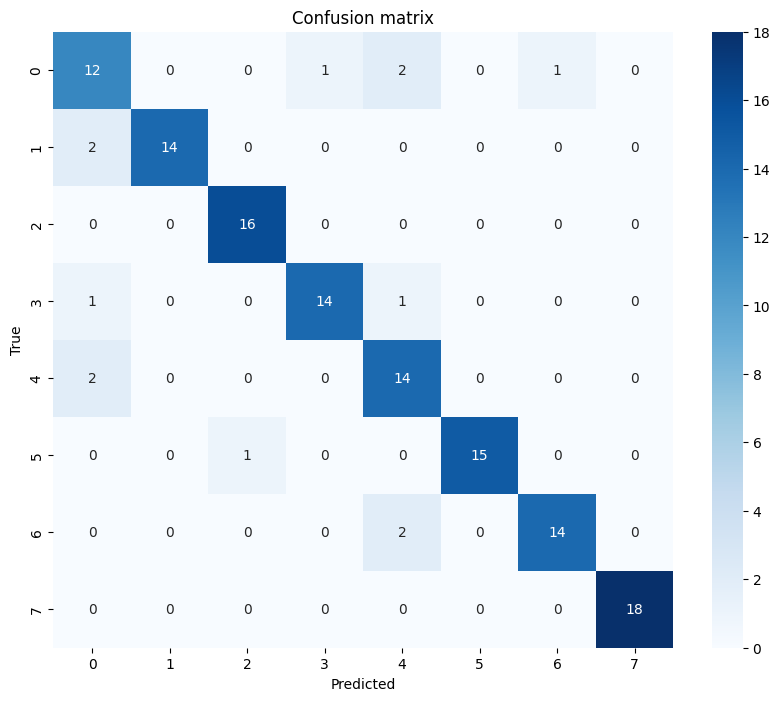

In [ ]:
test(model, test_dataloader, criterion, device)

In [ ]:
import numpy as np

def calculate_energy(outputs):
    return -torch.logsumexp(outputs, dim=1)

def analyze_energy_distribution(model, dataloader, device):
    model.eval()
    energies = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            energy = calculate_energy(outputs)
            energies.extend(energy.cpu().numpy())
    return energies

energies = analyze_energy_distribution(model, train_dataloader, device)

energy_threshold = np.percentile(energies, 95)

print(f"Energy Threshold: {energy_threshold}")

Energy Threshold: -3.5456230640411377


In [ ]:
model_name = 'efficientnet.pth'

torch.save(model.state_dict(), model_name)
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(model_name)

ArtifactManifestEntry(path='efficientnet.pth', digest='4eLpLEov5/ePA6EcWgC5Rg==', size=20023306, local_path='/root/.local/share/wandb/artifacts/staging/tmp1i4jaqkz', skip_cache=False)

In [ ]:
wandb.log_artifact(model_artifact)

<Artifact model>

In [ ]:
import numpy as np

def inference(model, image_path, device):
    image = Image.open(image_path)

    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image = transform(image=np.array(image))['image']
    image_tr = torch.tensor(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image_tr)
        energy = calculate_energy(output)
        if energy > energy_threshold:
            print(f"The class is of unknown origin")
            print(f"Its energy is {energy}, but the threshold is {energy_threshold}")
            return
        prob = torch.softmax(output, dim=1)
        s, predicted_class = torch.max(prob,  1)
        print(f"Probability: {s}")
        print(f"Predicted class: {predicted_class}")
        print("-------------------------------------\n")
        return s

tests_dir = "/content/drive/MyDrive/test images"

avg = []

for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
    # avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")


<ipython-input-29-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


Probability: tensor([0.9552], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.9907], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

Probability: tensor([0.9689], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

Probability: tensor([0.9998], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-2.5297], device='cuda:0'), but the threshold is -3.5456230640411377
Probability: tensor([0.9012], device='cuda:0')
Predicted class: tensor([2], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-2.8785], device='cuda:0'), but the threshold is -3.5456230640411377
Probability: tensor([0.6717], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
---

In [ ]:
tests_dir = "/content/drive/MyDrive/original(resized)/test/Anthracnose_Fungi"

avg = []
for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
#     avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")

<ipython-input-29-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


The class is of unknown origin
Its energy is tensor([-3.0512], device='cuda:0'), but the threshold is -3.5456230640411377
Probability: tensor([0.9375], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.8964], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-3.2377], device='cuda:0'), but the threshold is -3.5456230640411377
The class is of unknown origin
Its energy is tensor([-3.2419], device='cuda:0'), but the threshold is -3.5456230640411377
Probability: tensor([0.4235], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-3.2731], device='cuda:0'), but the threshold is -3.5456230640411377
Probability: tensor([0.8824], device='cuda:0')
Predicted class: tensor([1], device='cuda:0')
-----------------------

In [ ]:
notebook_name = "/content/drive/MyDrive/Colab Notebooks/NN_resnet18_aug.ipynb"
with open(notebook_name) as f:
    nb = nbformat.read(f, as_version=4)
artifact = wandb.Artifact('notebook', type='notebook')
artifact.add_file(notebook_name)
wandb.log_artifact(artifact)

<Artifact notebook>

In [ ]:
wandb.finish()

accuracy,▁
f1 score,▁
precision,▁
recall,▁
test loss,▁
accuracy,0.9
f1 score,0.90209
precision,0.90776
recall,0.9
test loss,0.18918
